# サプライ・チェイン基本分析システム SCBAS

> 基本分析モジュール abc とサプライ・チェイン基本分析システム SCBAS (Supply Chain Basic Analytics System) 

In [ ]:
#| default_exp abc

In [ ]:
#| export
#data generation moduleのインポート
import sys
sys.path.append('..')
from scmopt2.data import *

import colorlover as cl
from geopy.distance import great_circle as distance
import pickle
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import plotly

import pandas as pd
import random
import string
import datetime
import math
from collections import OrderedDict, defaultdict
import networkx as nx

from typing import List, Optional, Union, Tuple, Dict, Set, Any, DefaultDict
from pydantic import BaseModel, Field, ValidationError, validator, confloat, conint, constr, Json, ConfigDict
from pydantic.tools import parse_obj_as

folder = "./data/"
mapbox_access_token = 'pk.eyJ1IjoibWlraW9rdWJvIiwiYSI6ImNqYXQ3dHBqdzR5ZGwyd3BkeG5rOTl0b2UifQ.1utsXNi2V-WdzfWlvCMj_A'

In [ ]:
#| echo: false
from IPython.display import Image, YouTubeVideo
# YouTubeVideo("H2t6bHlsTP8")

## はじめに

サプライ・チェイン・アナリティクスで最初に行うことは、需要データに対するABC分析である。
商品の需要量というのは、売れるものはたくさん売れるが、その数はごく少数であり、他のたくさんのそんなに売れない商品が山ほどあるという性質を持つ。
これをパレートの法則（全体の数値の大部分は、全体を構成するうちの一部の要素が生み出しているという理論。別名、80:20の法則、もう1つの別名、ばらつきの法則）と呼ぶ。

ここでは、仮想の企業の需要を生成し、それに対してABC分析を行う。
同時に、商品を売れている順に順位をつけ、順位の時系列的な変化を示すランク分析を提案する。

さらに、簡単な在庫分析を行う。これは、平均需要量や生産固定費用から、生産ロットサイズや安全在庫量を計算するものであり、
古典的な経済発注量モデルや安全在庫モデル（新聞売り子モデル）に基づくものである。

## データの読み込み

まずは基本となるデータを読み込む。製品データはオプションであり、需要を売り上げや需要を重量や容量で評価したい場合に使う。
基本は、需要データ demand_df だけを使えば十分である。

需要データは以下の列をもつ．

- date: 日付
- cust: 顧客名
- prod: 製品名
- demand: 需要量
- sales: 売上

需要量demandと売上の何れかに対して，ABC分析を行う．

In [ ]:
prod_df = pd.read_csv(folder+"prod.csv",index_col=0)
prod_df.head()

,name,weight,volume,cust_value,dc_value,plnt_value,fixed_cost
0,A,2,0,7,1,1,14
1,B,5,0,5,1,1,14
2,C,1,0,5,1,1,19
3,D,3,0,5,1,1,17
4,E,1,0,10,1,1,18


In [ ]:
#| include: false
# Scbas用に必要なデータだけ切り出したデータフレームを生成
prod_df = prod_df[ ["name", "plnt_value", "fixed_cost"] ]
#prod_df.to_csv(folder+"prod_for_scbas.csv")

In [ ]:
demand_df = pd.read_csv(folder+"demand_with_promo_all.csv",index_col=0)
demand_df.head()

,date,cust,prod,promo_0,promo_1,demand
0,2019-01-01,札幌市,A,0,0,6
1,2019-01-01,札幌市,B,0,0,6
2,2019-01-01,札幌市,C,0,0,6
3,2019-01-01,札幌市,D,0,0,5
4,2019-01-01,札幌市,E,0,0,11


## Kaggleデータの読み込み

以下で配布されているデータを読み込む．

https://www.kaggle.com/kyanyoga/sample-sales-data

Kaggleデータを用いたい場合には，以下を実行する． ただし，製品データがないので，製品関連の関数は適用できない．


In [ ]:
kaggle_df = pd.read_csv(folder + "sales_data_sample.csv", encoding="latin")
kaggle_df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [ ]:
kaggle_df["date"] = pd.to_datetime(kaggle_df.ORDERDATE)
kaggle_df.rename(columns={"PRODUCTLINE":"prod", "CITY":"cust", "QUANTITYORDERED":"demand", "SALES":"sales"}, inplace=True)
kaggle_demand_df = kaggle_df[["date","cust","prod","demand","sales"]].copy()
kaggle_demand_df.head()

,date,cust,prod,demand,sales
0,2003-02-24,NYC,Motorcycles,30,2871.00
1,2003-05-07,Reims,Motorcycles,34,2765.90
2,2003-07-01,Paris,Motorcycles,41,3884.34
3,2003-08-25,Pasadena,Motorcycles,45,3746.70
4,2003-10-10,San Francisco,Motorcycles,49,5205.27


## 需要と売り上げのtreemapを生成する関数 demand_tree_map

引数：
- demand_df: 需要データフレーム（需要 demand と売り上げ sales の列を含む）
- parent: 入れ子にする際の親項目； "cust" （既定値） もしくは "prod" を入れる． 
- value: 評価に使用する列名； 既定値は "demand" で， "sales" などを計算した列がデータフレーム内にあればそれを指定する．
  
返値：
- Plotlyのtreemapオブジェクト


In [ ]:
#| export
def demand_tree_map(demand_df: pd.DataFrame, 
                    parent: str = "cust",
                    value: str  = "demand") -> plotly.graph_objects.Figure:
    """
    需要と売り上げのtreemapを生成する関数
    """
    
    if "date" not in demand_df.columns:
        demand_df.reset_index(inplace=True)
    demand_df["date"] = pd.to_datetime(demand_df.date)
    demand_df.set_index("date", inplace=True)

    #periods = max( (demand_df.index.max() - demand_df.index.min()).days, 1) #計画期間

    total_demand_df=pd.pivot_table(
            demand_df, index = ["prod","cust"], values = value, aggfunc = "sum")
    total_demand_df.reset_index(inplace=True)
    
    # treemap: pathで入れ子にする順番を決める（最初が親）；
    if parent =="cust":
        fig = px.treemap(total_demand_df, path=['cust','prod'], values=value, color_continuous_scale='RdBu')
    else:
        fig = px.treemap(total_demand_df, path=['prod','cust'], values=value, color_continuous_scale='RdBu')
        
    return fig

### demand_tree_mapの使用例

sales列がない場合には，dataモジュールのdemand_attribute_compute関数を用いてsales（売り上げ）列を計算することができる。

需要のtreemapは，需要の大きさを面積とした階層図であり，売上は色で表現している．


In [ ]:
#| include: false 
# Salesの列を追加したい場合
# prod_df = pd.read_csv(folder+"prod_for_scbas.csv")
# demand_df = demand_attribute_compute(demand_df, prod_df, "plnt_value", "sales")
# #demand_df.to_csv(folder+"demand.csv")
# demand_df.head()

In [ ]:
fig = demand_tree_map(demand_df, parent ="prod", value = "demand");
#plotly.offline.plot(fig);

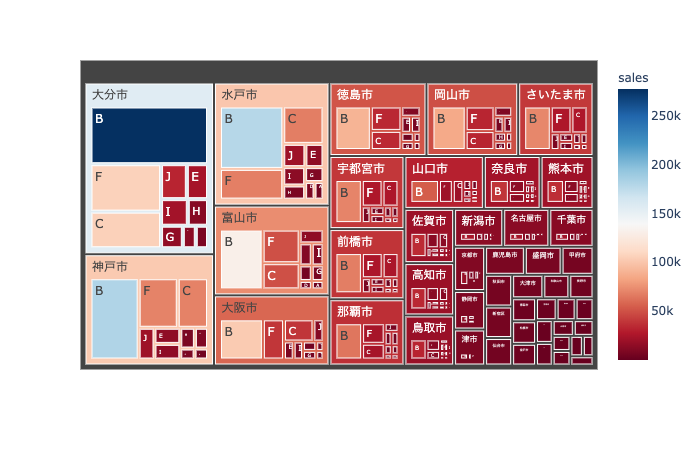

In [ ]:
#| echo: false
Image("../figure/treemap.png")

## ABC分析とランク分析を行うための関数 abc_analysis

ABC分析のための関数を記述する、基本的には、需要データ demand_df だけあれば良いが、顧客や製品に関連した量を分析に加えたいときには、顧客データ cust_df や
製品データ prod_df も読み込んでおく。

古典的なABC分析では、3つのカテゴリーに製品や顧客を分類していたが、場合によっては4つに分類したい場合もあるだろう。
ここでは、より一般的にユーザーが与えた任意の数への分類を行う関数を準備する、カテゴリーに含まれる需要量を、ユーザーが与えた閾値をもとにして分類を行う。

引数:
       
- demand_df: ABC分析を行うための需要データフレーム．列に集約を行うための列と値を格納した列が必要．
- threshold: A,B,C の分類を行うための閾値．上位 threshold[0]の要素がAランク，次に上位の threshold[1]がBランク、と順に決めていく。
リストの長さは（アルファベットの数以下の）任意の正数であるが、合計が1以上になるような数値のリストとして与える．
- agg_col: 集約を行う列名を文字列として与える．
- value: A,B,Cの分類を行うための数値データを保管した列名を文字列として与える．
- abc_name: 分類した結果を入れるための列名を文字列として与える．
- rank_name: 数値データの順位を入れた列名を文字列として与える．

返値:  以下の3つのオブジェクトのタプル：
      
- agg_df: agg_colによって集約したデータをvalueの数値の大きい順に並べたデータフレーム．abcとrankの情報が付加されている．
- new_df: 元のデータフレームにabc_nameで与えた列にA(=0),B(=1),C(=2),...の分類を，rank_nameで与えた列にランク（順位）を入れている．
- category: 0,1,2, ...をキーとして与えると A,B,C,... ランクに属するデータ名（agg_colの要素）のリストを値として返す辞書．


In [ ]:
#| export
def abc_analysis(demand_df: pd.DataFrame, 
                 threshold: List[float], 
                 agg_col: str = "prod", 
                 value: str ="demand",
                 abc_name: str ="abc",
                 rank_name: str ="rank"
                ) -> Tuple[ pd.DataFrame, pd.DataFrame, Dict[int, List[str]] ] :
    """
    ABC分析のための関数
    """
    assert(sum(threshold) >=0.99)
    threshold = np.array(threshold)
    # print(threshold)
    theta = threshold.cumsum()  # ABC分析の閾値(累積量が閾値を超えるまでABCに分類）
    df = demand_df.copy()
    
    #ランク（大きいほど高い）
    temp_series = df.groupby([agg_col])[value].sum()
    sorted_series = temp_series.sort_values(ascending=False)

    # ABC分析のための準備：
    ind = []  # 値を降順に並べたときの名のリスト
    dem = []  # 値の降順に並べたときの量
    for i in sorted_series.index:
        ind.append(str(i))
        dem.append(sorted_series[i])

    # 0,1,2 ...を　A,B,C ... に変換するための辞書 map_ を準備
    alphabet = string.ascii_uppercase
    map_ = {}
    for i, a in enumerate(alphabet):
        map_[i] = a

    cum = 0
    count = 0
    total = sorted_series.sum()
    category = {i: [] for i in range(len(threshold))}
    rank = np.zeros(len(ind), dtype=np.int32)
    abc = np.zeros(len(ind), dtype=str)
    idx_ub = []
    for i in range(len(ind)):
        abc[i] = map_[count]
        cum += dem[i]
        category[count].append(ind[i])
        if cum > total * theta[count] and count<len(theta)-1:
            idx_ub.append(i)
            count += 1
        rank[i] = i

    idx_ub.append(len(ind))
    # print(category[0])       # 0がA, 1がB， 2がC

    agg_df = pd.DataFrame(sorted_series)
    agg_df["rank"] = rank
    agg_df["abc"] = abc

    abc = agg_df.to_dict()["abc"]
    rank = agg_df.to_dict()["rank"]
    name_list = list(df[agg_col])
    abc_column = []
    rank_column = []
    for name in name_list:
        abc_column.append(abc[name])
        rank_column.append(rank[name])
    df[abc_name] = abc_column
    df[rank_name] = rank_column

    return agg_df, df, category

### 顧客・製品の組に対するABC分析 abc_analysis_all 

顧客・製品ごとに需要予測を行う際に，予測しなくても良い組を予め抜き出しておくことが重要になる．そのため，顧客・製品の組に対してABC分析とランク分析を行う関数を準備しておく．

引数:
       
- demand_df: ABC分析を行うための需要データフレーム．列に集約を行うための列と値を格納した列が必要．
- threshold: A,B,C の分類を行うための閾値．上位 threshold[0]の要素がAランク，次に上位の threshold[1]がBランク、と順に決めていく。

返値:  以下の3つのオブジェクトのタプル：
      
- agg_df: 顧客・製品によって集約したデータをdemandの数値の合計（sum)の大きい順に並べたデータフレーム． abcとrankと需要の標準偏差 (std) の情報が付加されている．
- category: 0,1,2, ...をキーとして与えると A,B,C,... ランクに属するデータ名（agg_colの要素）のリストを値として返す辞書．


In [ ]:
#| export
def abc_analysis_all(deamnd_df: pd.DataFrame,
                     threshold: List[float]
                    ) -> Tuple[ pd.DataFrame, Dict[int, List[str]] ]:
    assert(sum(threshold) >=0.99)
    threshold = np.array(threshold)
    theta = threshold.cumsum()  # ABC分析の閾値(累積量が閾値を超えるまでABCに分類）
    temp_series = pd.pivot_table(demand_df, values="demand", index=["cust","prod"],aggfunc= ["sum","std"] )
    sorted_series = temp_series.sort_values(by=('sum', 'demand'),ascending=False)
    # ABC分析のための準備：
    ind = []  # 値を降順に並べたときの名のリスト
    dem = []  # 値の降順に並べたときの量
    for i,j in sorted_series.index:
        ind.append((str(i),str(j))) 
        dem.append(sorted_series.loc[(i,j),('sum', 'demand')])
    # 0,1,2 ...を　A,B,C ... に変換するための辞書 map_ を準備
    alphabet = string.ascii_uppercase
    map_ = {}
    for i, a in enumerate(alphabet):
        map_[i] = a

    cum = 0
    count = 0
    total = sorted_series[('sum', 'demand')].sum()
    category = {i: [] for i in range(len(threshold))}
    rank = np.zeros(len(ind), dtype=np.int32)
    abc = np.zeros(len(ind), dtype=str)
    idx_ub = []
    for i in range(len(ind)):
        abc[i] = map_[count]
        cum += dem[i]
        category[count].append(ind[i])
        if cum > total * theta[count] and count<len(theta)-1:
            idx_ub.append(i)
            count += 1
        rank[i] = i

    idx_ub.append(len(ind))
    # print(category[0])       # 0がA, 1がB， 2がC

    agg_df = pd.DataFrame(sorted_series)
    agg_df["rank"] = rank
    agg_df["abc"] = abc
    agg_df.columns = agg_df.columns.get_level_values(0) #列の階層をフラットにする．

    return agg_df, category

## abc_analysis(_all)関数の使用例

以下では、製品と顧客に対してABC分析を行い、得られた3種類のデータフレーム（元のデータフレームに列を追加したもの：new_df、製品データフレームagg_df_prod、顧客データフレーム：agg_df_cust）を示す。

- 確認用の小規模例
- 製品を需要量を元に3つのクラスに、閾値[0.4, 0.5, 0.1]を用いて分類
- 顧客を需要量を元に4つのクラスに、閾値[0.4, 0.3, 0.3, 0.1]を用いて分類
- 顧客・製品を元に4つのクラスに、閾値[0.4, 0.3, 0.3, 0.1]を用いて分類

In [ ]:
df = pd.DataFrame({"prod":[1,2,3,4,5], "demand": [10,30,40,50,80]})
threshold = [0.4, 0.5, 0.2]
agg_df, new_df, category = abc_analysis(df, threshold, "prod", "demand", "abc", "rank")
print(category)
new_df

{0: ['5', '4'], 1: ['3', '2'], 2: ['1']}


,prod,demand,abc,rank
0,1,10,C,4
1,2,30,B,3
2,3,40,B,2
3,4,50,A,1
4,5,80,A,0


In [ ]:
demand_df = pd.read_csv(folder+"demand_with_promo_all.csv",index_col=0)
threshold = [0.4, 0.5, 0.1]
agg_df, new_df, category = abc_analysis(demand_df = demand_df, threshold=threshold,
                                        agg_col="prod", value= "demand", abc_name="abc", rank_name="rank")
print(category)
new_df.head()

{0: ['E', 'J', 'H'], 1: ['A', 'B', 'G', 'F', 'C', 'D'], 2: ['I']}


,date,cust,prod,promo_0,promo_1,demand,abc,rank
0,2019-01-01,札幌市,A,0,0,6,B,3
1,2019-01-01,札幌市,B,0,0,6,B,4
2,2019-01-01,札幌市,C,0,0,6,B,7
3,2019-01-01,札幌市,D,0,0,5,B,8
4,2019-01-01,札幌市,E,0,0,11,A,0


In [ ]:
agg_df_cust, new_df, category_cust = abc_analysis(
    demand_df, [0.4, 0.3, 0.3, 0.1], 'cust', 'demand', "customer_ABC", "customer_rank")
new_df.head()

,date,cust,prod,promo_0,promo_1,demand,customer_ABC,customer_rank
0,2019-01-01,札幌市,A,0,0,6,C,27
1,2019-01-01,札幌市,B,0,0,6,C,27
2,2019-01-01,札幌市,C,0,0,6,C,27
3,2019-01-01,札幌市,D,0,0,5,C,27
4,2019-01-01,札幌市,E,0,0,11,C,27


In [ ]:
demand_df

,date,cust,prod,promo_0,promo_1,demand
0,2019-01-01,札幌市,A,0,0,6
1,2019-01-01,札幌市,B,0,0,6
2,2019-01-01,札幌市,C,0,0,6
3,2019-01-01,札幌市,D,0,0,5
4,2019-01-01,札幌市,E,0,0,11
...,...,...,...,...,...,...
343095,2020-12-30,那覇市,F,1,1,12
343096,2020-12-30,那覇市,G,1,1,12
343097,2020-12-30,那覇市,H,1,1,16
343098,2020-12-30,那覇市,I,1,1,10


In [ ]:
agg_df_cust.head()

,demand,rank,abc
cust,,,
佐賀市,566776,0,A
静岡市,308021,1,A
岡山市,257539,2,A
那覇市,158134,3,A
京都市,149615,4,A


In [ ]:
agg_df,category = abc_analysis_all(demand_df, threshold=[0.4, 0.3, 0.3, 0.1])
#print(category)
agg_df.head()

sum        std  rank abc
cust prod                            
佐賀市  E     87858  59.304760     0   A
     J     73705  49.763944     1   A
     H     63240  40.927453     2   A
     A     54031  38.126906     3   A
     B     52751  35.582571     4   A

### 元のデータフレームにabcとrankとdemandを追加する関数 add_abc

引数：
- df: 製品や顧客のデータフレーム；これにABC分析の結果を追加する．
- agg_df: 集約した需要（もしくは売上），ABC分類，ランクを保管したデータフレーム；インデックスは製品(prod)もしくは顧客 (cust)
- col_name: 追加したいデータの列名；製品の場合にはprod（既定値），顧客の場合にはcust
- value: 追加したい列名；既定値は "demand"

返値：
- df: ランク，ABC分類，集約した需要量を追加したデータフレーム

In [ ]:
#| export
def add_abc(df: pd.DataFrame, 
            agg_df: pd.DataFrame, 
            col_name: str ="prod",
            value:str ="demand"
           ) -> pd.DataFrame:
    try:
        agg_df.reset_index(inplace=True)
    except:
        pass
    dic_ = {}
    for key, dem, rank, abc in zip(agg_df[col_name], agg_df[value], agg_df["rank"], agg_df["abc"]):
        dic_[ key ] = (dem, rank, abc)
    dem_list, rank_list, abc_list =[], [], [] 
    for row in df.itertuples():
        dem_list.append( dic_[row.name][0] )
        rank_list.append( dic_[row.name][1] )
        abc_list.append( dic_[row.name][2] )
    df[value] = dem_list
    df["rank"] = rank_list
    df["abc"] = abc_list
    return df

### add_abc関数の使用例

In [ ]:
cust_df = pd.read_csv(folder+"cust.csv", index_col=0)
new_cust_df = add_abc(df = cust_df, agg_df = agg_df_cust, col_name="cust", value="demand")
new_cust_df.head()

,name,lat,lon,demand,rank,abc
id,,,,,,
1,札幌市,43.06417,141.34694,48954,27,C
2,青森市,40.82444,140.74000,80974,13,B
3,盛岡市,39.70361,141.15250,35997,43,C
4,仙台市,38.26889,140.87194,43341,32,C
5,秋田市,39.71861,140.10250,39103,38,C


## ABC別に色分けした需要のtreemapを生成する関数 

引数：
- demand_df: ABC分析の結果の列を含む需要データフレーム
- abc_col: ABC分析の結果の列名

返値：
- Plotlyのtreemapオブジェクト


In [ ]:
#| export
def demand_tree_map_with_abc(demand_df: pd.DataFrame, abc_col: str) ->plotly.graph_objects.Figure:
    """
    ABC別に色分けした需要のtreemapを生成する関数
    """
    if "date" not in demand_df.columns:
        demand_df.reset_index(inplace=True)
    demand_df["date"] = pd.to_datetime(demand_df.date)
    demand_df.set_index("date", inplace=True)

    #periods = max( (demand_df.index.max() - demand_df.index.min()).days, 1) #計画期間

    total_demand_df=pd.pivot_table(
            demand_df, index = ["prod","cust",abc_col], values = "demand", aggfunc = "sum")
    total_demand_df.reset_index(inplace=True)
    # Treemap: pathで入れ子にする順番を決める（最初が親）；
    fig = px.treemap(total_demand_df, path=['cust','prod'], values='demand', color=abc_col,
                    color_continuous_scale='RdYlBu')
    return fig

### demand_tree_map_with_abc関数の使用例

In [ ]:
agg_df_cust, new_df, category_cust = abc_analysis(
    demand_df, [0.4, 0.3, 0.3, 0.1], 'cust', 'demand', "customer_ABC", "customer_rank")
fig = demand_tree_map_with_abc(new_df, abc_col="customer_ABC")
#plotly.offline.plot(fig);

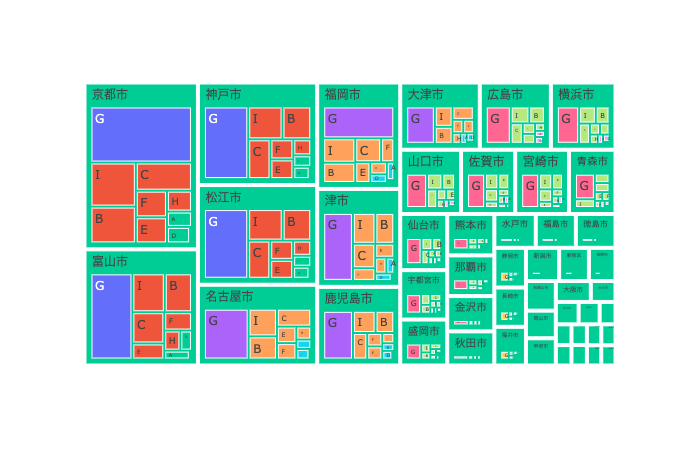

In [ ]:
#| echo: false
Image("../figure/demand_tree_map_with_abc.png")

## 需要データフレームからABC分析の図とデータフレームを生成する関数 generate_figures_for_abc_analysis

顧客と製品の両方に対するABC分析を同時に行い、結果の図とデータフレームを同時に得るには、この関数を用いる。

引数：

- demand_df : 需要データフレーム
- value: 分析をするデータが入っている列名（既定値は"demand"）
- cumsum : 図を累積値で描画するときには True
- cust_thres : 顧客のABC分析するときの閾値を文字列で表したもの
- prod_thres : 製品のABC分析するときの閾値を文字列で表したもの

返値：

- fig_prod : 製品のABC分析のPlotly図オブジェクト
- fig_cust : 顧客のABC分析のPlotly図オブジェクト
- agg_df_prod : 製品をインデックスとしたABC分析のデータフレーム 
- agg_df_cust : 顧客をインデックスとしたABC分析のデータフレーム 
- new_df : 顧客と製品のABCとランクを加えた新しい需要データフレーム
- category_prod (cust): 0,1,2, ...をキーとして与えると A,B,C,... ランクに属するデータ名（agg_colの要素）のリストを値として返す辞書； category_prodは製品， category_custは顧客の情報をもつ．

In [ ]:
#| export
def generate_figures_for_abc_analysis(demand_df: pd.DataFrame,
                                      value: str = "demand",
                                      cumsum: bool =True, 
                                      cust_thres: str = "0.7, 0.2, 0.1",
                                      prod_thres: str = "0.7, 0.2, 0.1"
                                     ) -> Tuple[plotly.graph_objects.Figure,plotly.graph_objects.Figure,
                                                pd.DataFrame,pd.DataFrame,pd.DataFrame] :
    # 閾値の計算
    cust_threshold = [float(i) for i in cust_thres.split(",")]
    prod_threshold = [float(i) for i in prod_thres.split(",")]

    # ABC分析
    agg_df_prod, new_df, category_prod = abc_analysis(
        demand_df, prod_threshold, 'prod', value, "prod_ABC", "prod_rank")
    agg_df_cust, new_df, category_cust = abc_analysis(
        demand_df, cust_threshold, 'cust', value, "customer_ABC", "customer_rank")

    # 製品ABC分析のヒストグラムの生成
    if cumsum:
        agg_df_prod["cumsum_prod"] = agg_df_prod[value].cumsum()

    scales = cl.scales[str(len(category_prod))]['div']['RdYlBu']
    color_list = []
    for i in range(len(category_prod)):
        color_list.extend([scales[i]]*len(category_prod[i]))
    if cumsum:
        y_ = agg_df_prod["cumsum_prod"]/agg_df_prod["cumsum_prod"][-1]
    else:
        y_ = agg_df_prod[value]
    trace = go.Bar(
        x = agg_df_prod.index,
        y = y_,
        text = agg_df_prod.index,
        marker = dict(
            color=color_list
        )
    )
    data = [trace]
    if cumsum:
        layout = go.Layout(
            xaxis=dict(tickangle=-45),
            yaxis_tickformat = '%'
        )
    else:
        layout = go.Layout(
            xaxis=dict(tickangle=-45)
        )
        
    fig_prod = go.Figure(data=data, layout=layout)

    # 累積和の計算
    if cumsum:
        agg_df_cust["cumsum_cust"] = agg_df_cust[value].cumsum()
    
    # 顧客ABC分析のヒストグラムの生成
    scales = cl.scales[str(len(category_cust))]['div']['RdYlBu']
    color_list = []
    for i in range(len(category_cust)):
        color_list.extend([scales[i]]*len(category_cust[i]))
    if cumsum:
        y_ = agg_df_cust["cumsum_cust"]/agg_df_cust["cumsum_cust"][-1]
    else:
        y_ = agg_df_cust[value]

    trace = go.Bar(
        x = agg_df_cust.index,
        y = y_,
        #text = agg_df_cust.index,
        marker = dict(
            color = color_list
        )
    )
    data = [trace]
    if cumsum:
        layout = go.Layout(
            xaxis=dict(tickangle=-45),
            yaxis_tickformat = '%'
        )
    else:
        layout = go.Layout(
            xaxis=dict(tickangle=-45)
        )
    fig_cust = go.Figure(data=data, layout=layout)
        
    return fig_prod, fig_cust, agg_df_prod, agg_df_cust, new_df, category_prod, category_cust

### generate_figures_for_abc_analysis関数の使用例

In [ ]:
fig_prod, fig_cust, agg_df_prod, agg_df_cust, new_df, category_prod, category_cust = generate_figures_for_abc_analysis(
demand_df, value="demand", cumsum = False, cust_thres="0.7, 0.2, 0.1", prod_thres="0.7, 0.2, 0.1")
#plotly.offline.plot(fig_cust);

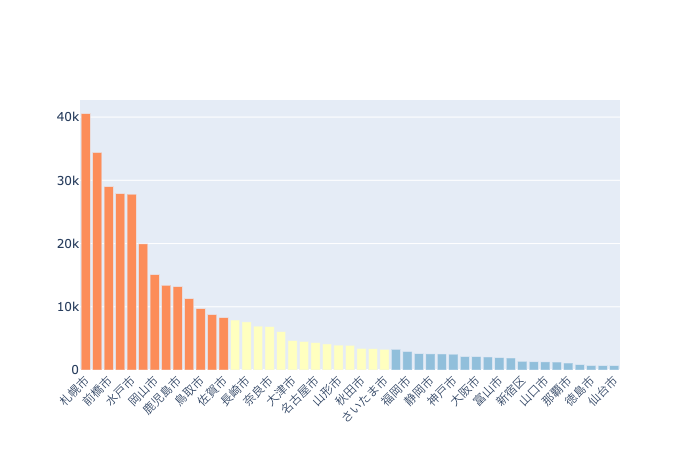

In [ ]:
#| echo: false
Image("../figure/generate_figure_for_abc.png")

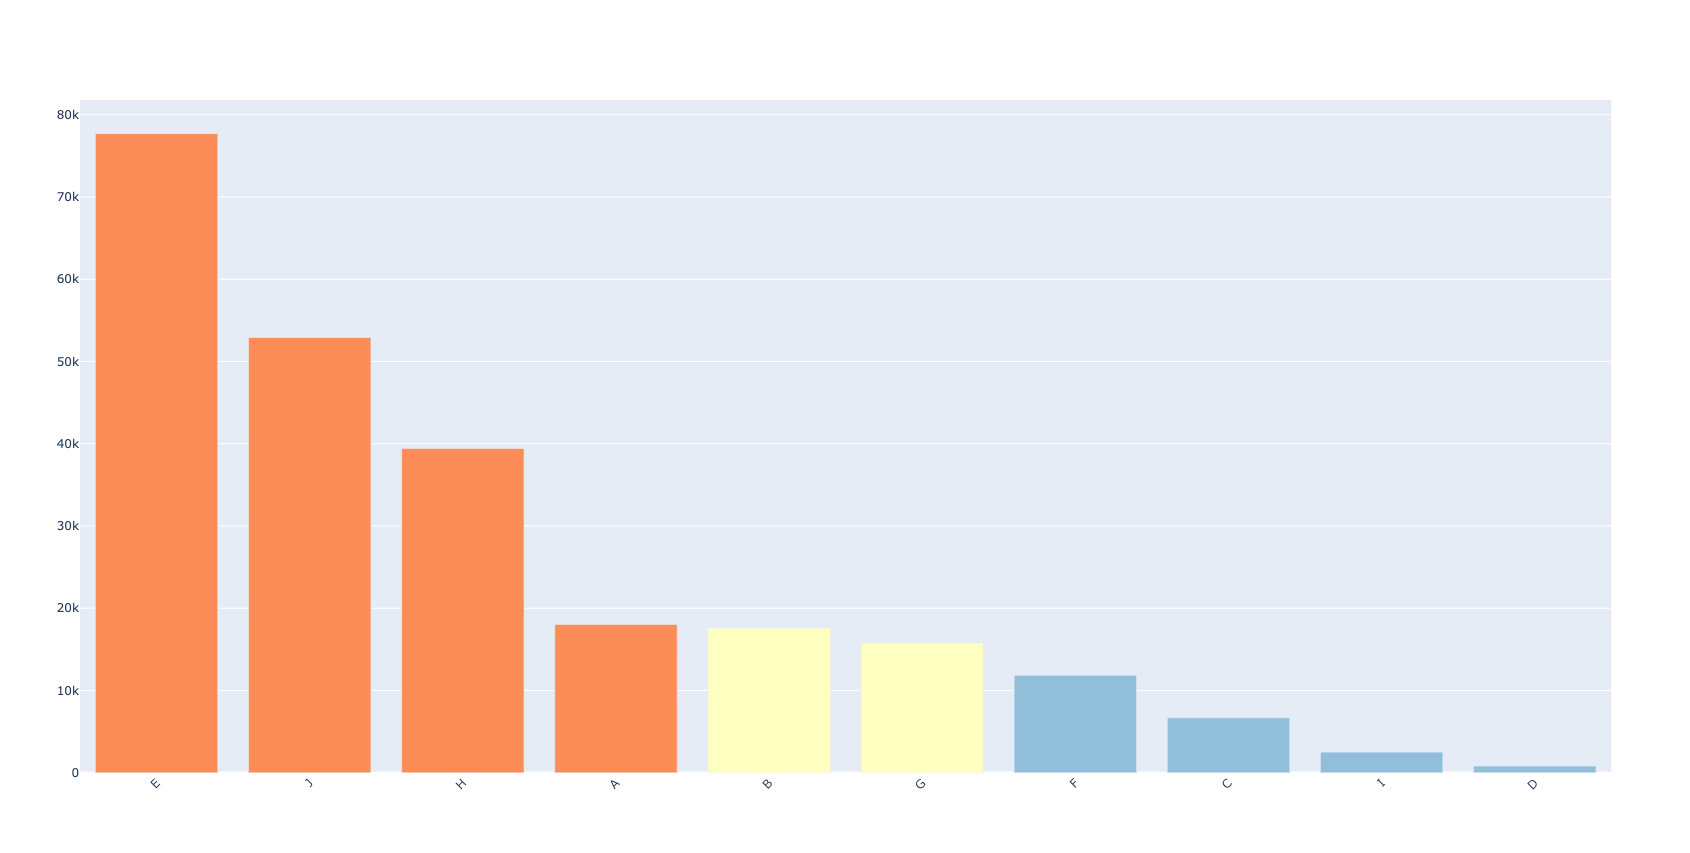

In [ ]:
#| echo: false
Image("../figure/generate_figures_for_abc_prod.png", width=800)

In [ ]:
#| include: false
# agg_df_cust.head()

In [ ]:
#| include: false
# new_df.head()

## ランク分析のための関数 rank_analysis と rank_analysis_all_periods

全ての期に対するランク分析を行う関数 rank_analysis と、期ごと（集約する単位は文字列で与える）のランク分析を行う関数 rank_analysis_all_periodsを記述する。


引数:

- df: ランク分析を行う対象の需要データフレーム．列に集約を行うための列と，値を格納した列が必要．
- agg_col: 集約を行う列名を文字列として与える．
- value: ランクを計算するための数値データを保管した列名を文字列として与える．
- agg_period （rank_analysis_all_periodsの場合のみ） : 集約を行う期間を "1m"（月次）のような文字列で与える．

返値: 

- 名前を入れるとランク（rank_analysisの場合）もしくランクの期別リスト（rank_analysis_all_periodsの場合）を返す辞書 

In [ ]:
#| export
def rank_analysis(df: pd.DataFrame, 
                  agg_col: str, 
                  value: str
                 ) -> Dict[int,int]:
    """
    全期間分のランク分析のための関数
    """
    temp_series = df.groupby([agg_col])[ value ].sum()
    sorted_series = temp_series.sort_values(ascending=False)
    rank = { } # ランクを格納する辞書
    count = 0
    for i in sorted_series.index:
        count += 1
        rank[i] = count
    return rank

In [ ]:
#| export
def rank_analysis_all_periods(df: pd.DataFrame, 
                              agg_col: str, 
                              value: str,
                              agg_period: str
                             ) -> Dict[str, List[int] ]:
    """
    期別のランク分析のための関数
    """
    try:
        df.reset_index(inplace=True)
    except:
        pass
    agg_set = set(df[agg_col].unique())  # 集約する対象の集合
    rank = {}  # 対象の期ごとのランクのリストを保持する辞書
    for i in agg_set:
        rank[i] = []
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)
    start_date = pd.to_datetime( min(df.index ))
    end_date = pd.to_datetime( max(df.index))
    for t in pd.date_range(start_date, end_date, freq=agg_period):
        selected_df = df[(df.index >= start_date ) & (df.index <= t)]  #ｓｔｒとdatetimeの比較！
        rank_in_period = rank_analysis(selected_df, agg_col, value)
        for i in rank:
            if i in rank_in_period:
                rank[i].append(rank_in_period[i])
            else:
                rank[i].append(np.nan)
        start_date = t
    df.reset_index(inplace=True)
    return rank

### ランク分析の関数の使用例

全期間分の顧客需要のランク分析と、３ヶ月を１期とした各期間に対する製品のランク分析。

In [ ]:
dic = rank_analysis(df=demand_df, agg_col='cust', value='demand') #全ての期間に対する顧客需要量のランク分析
dic.popitem()

('新潟市', 47)

In [ ]:
dic = rank_analysis_all_periods(df = demand_df, agg_col='prod', value= 'demand', agg_period="1d") 

## ランク分析の可視化関数 show_rank_analysis

ランクの時系列的な変化を表す図を生成するための関数。

引数:

- demand_df: ランク分析を行う対象の需要データフレーム．列に集約を行うための列と，値を格納した列が必要
- agg_df_prod: 製品のすべての期間に対するランクが保管されているデータフレーム；与えられない場合(引数がNoneの場合）には，abc_analysis関数で再計算する．
- value: 分析をするデータが入っている列名（既定値は"demand"）
- agg_period: 集約を行う期間を "1m"（月次）のような文字列で与える．
- top_rank: 上位 top_rank 個のものだけを表示する

返値: 

- Plotlyの図オブジェクト


In [ ]:
#| export
def show_rank_analysis(demand_df: pd.DataFrame,
                       agg_df_prod: pd.DataFrame = None, 
                       value: str ="demand", 
                       agg_period: str ="1m",
                       top_rank: int = 1
                      ) -> plotly.graph_objects.Figure:
    """
    ランク分析の可視化関数
    """
    try:
        demand_df.reset_index(inplace=True)
    except:
        pass
    agg_col = "prod"
    rank = rank_analysis_all_periods(
        demand_df, agg_col, value, agg_period)

    demand_df.set_index("date", inplace=True)
    x_range = [t for t in pd.date_range(
        min(demand_df.index), max(demand_df.index), freq=agg_period)]
    
    # 全期間での順位を得る
    if agg_df_prod is None:
        agg_df_prod, new_df, category_prod = abc_analysis(
            demand_df, [0.7,0.2,0.1] , agg_col, value, "ABC name", "Rank name")

    data = []
    for i in agg_df_prod.index[:int(top_rank)]:  # 全期間での順位の順に表示
        trace = go.Scatter(
            x= x_range,
            y= rank[i],
            mode='markers + lines',
            name=i,
            marker=dict(size=8,
                        #line= dict(width=1),
                        # color= "black",
                        opacity=0.3
                        ),
        )
        data.append(trace)

    layout = go.Layout(
        title="製品のランクの推移",
        xaxis=dict(
            tickangle=-45,
            title='期'
        ),
        yaxis=dict(
            title='ランク'
        )
    )
    return go.Figure(data=data, layout=layout)

### show_rank_analysis関数の使用例

In [ ]:
fig = show_rank_analysis(demand_df, value="demand", agg_period ="1d", top_rank = 10)
#plotly.offline.plot(fig);

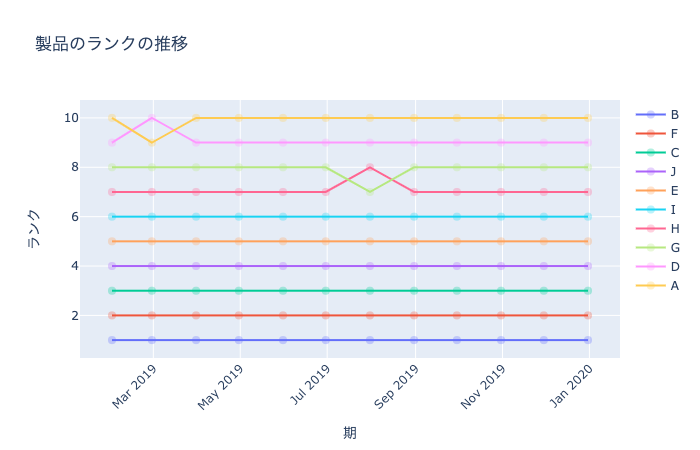

In [ ]:
#| echo: false
Image("../figure/show_rank_analysis.png")

## リスク共同管理分析 risk_pooling_analysis

在庫をサプライ・チェインの上流（供給側）でもつか、下流（需要側）でもつかは、複数の需要地点（顧客）における需要の相関で決まる。
一般には、上流で在庫を共有することによって在庫の削減ができる。これをリスク共同管理 (risk pooling) とよぶ。

ここでは、製品ごとに、顧客の需要の標準偏差とリスク共同管理した場合の標準偏差の差を計算する。
また、それを需要の総量で割った比率（削減率）も計算する。
これは、標準偏差を平均値で割ることによる無次元の指標（変動係数： coefficient of variation: CV)に相当するものである。

この値が大きい製品ほど、リスク共同管理の効果が大きいので、サプライ・チェインの上流で在庫を保持した方が良いことになり、
逆に小さい製品ほど、下流で在庫を保持した方が良いことになる。

引数：
- demand_df: 需要のデータフレーム
- agg_period: 標準偏差を計算する際に用いる需要の集約を行う期（規定値は週）

返値：
- inv_reduction_df : 標準偏差とその差と削減率を製品ごとに計算したデータフレーム； Rank列は製品の順位
    

In [ ]:
#| export
def risk_pooling_analysis(demand_df: pd.DataFrame, 
                          agg_period="1w"
                         ) -> pd.DataFrame:
    """
    リスク共同管理の効果を見るための関数

    在庫を顧客側においた場合と、倉庫側においた場合の差を、標準偏差を計算することによって推定する。

    """
    try:
        demand_df.reset_index(inplace=True)
    except:
        pass

    demand_df["date"] = pd.to_datetime(demand_df.date)
    demand_df.set_index("date", inplace=True)

    attr =["prod","agg_std","sum_std","reduction","rank"]
    dic = {i: [] for i in attr}

    rank_dic = rank_analysis(demand_df, 'prod', 'demand')

    for p in set(demand_df["prod"]):
        dem_for_prod = demand_df[demand_df["prod"] == p]
        dem = dem_for_prod.groupby(["cust"]).resample(
            agg_period)["demand"].sum()
        alldem = dem_for_prod.resample(agg_period)["demand"].sum()
        agg_std = alldem.std()
        s = 0.
        for c in set(demand_df.cust):
            if c in dem:
                d = dem[c]
                std = d.std()
                if math.isnan(std):
                    pass
                else:
                    s += d.std()
        # print(p, agg_std, std, agg_std/std) #標準偏差の比率
        # print(p,s - agg_std)  #削減可能な在庫量 （ * z sqrt{LT (week)})
        dic["prod"].append(p)
        dic["agg_std"].append(agg_std)
        dic["sum_std"].append(s)
        dic["reduction"].append(s - agg_std)
        #dic["reduction_ratio"].append( (s - agg_std)/(alldem.sum()+0.00001))
        dic["rank"].append( rank_dic[p] )
    inv_reduction_df = pd.DataFrame(dic, columns=attr)
    inv_reduction_df.set_index("rank",inplace=True)
    inv_reduction_df.sort_values("reduction", ascending=False, inplace=True)
    inv_reduction_df.reset_index(inplace=True)
    return inv_reduction_df

### risk_pooling_analysis関数の使用例

１週間を単位とした標準偏差をもとに、在庫を倉庫に置いた場合と工場に置いた場合の差を計算し、それを需要の総量で除した削減率(ReductionRatioの列）を計算する。
Plotlyによる可視化では、削減率の大きいものから棒グラフで表示し、需要の大きさのランクで色分けをする。

In [ ]:
inv_reduction_df = risk_pooling_analysis(demand_df, agg_period="1w")
inv_reduction_df.head()

,rank,prod,agg_std,sum_std,reduction
0,10,I,1137.883708,1138.748290,0.864583
1,8,C,1120.054537,1120.794951,0.740414
2,9,D,1114.387806,1115.096672,0.708866
3,4,A,1363.027889,1363.691051,0.663161
4,7,F,1282.927125,1283.552063,0.624938


## 在庫削減量の可視化関数 show_inventory_reduction

In [ ]:
#| export
def show_inventory_reduction(inv_reduction_df: pd.DataFrame
                            ) -> plotly.graph_objects.Figure:
    """
    在庫削減量の可視化関数
    """
    try:
        inv_reduction_df.reset_index(inplace=True)
    except ValueError:
        pass
    fig = px.bar(inv_reduction_df,x="prod",y="reduction",color="rank")
    fig.update_layout(xaxis_tickangle=-45)
    return fig

In [ ]:
fig = show_inventory_reduction(inv_reduction_df)
#plotly.offline.plot(fig);

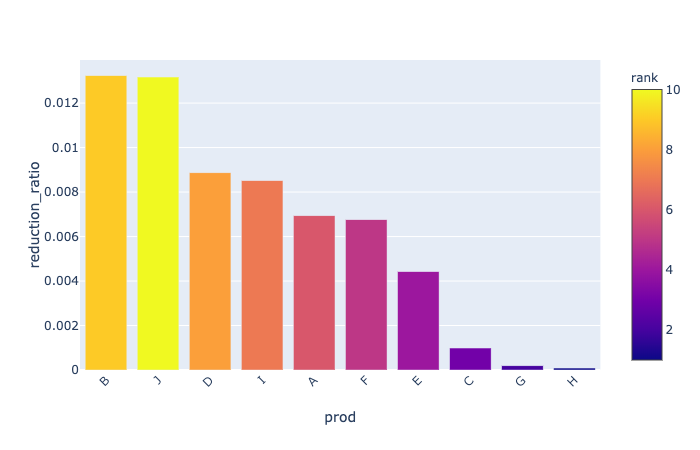

In [ ]:
#| echo: false
Image("../figure/show_inventory_reduction.png")

## 需要の製品ごとの平均と変動係数の可視化関数 show_mean_cv

需要を製品ごとに集約し，横軸に平均，縦軸に変動係数($CV=\sigma/\mu$)の対数をとった散布図を生成する．

平均が大きく，変動係数が小さい製品は安定しているので倉庫（サプライ・チェインの下流）で保管し，平均が小さく変動係数が大きい製品は，工場（サプライ・チェインの上流）で
保管し，適宜顧客側に流す戦略が望ましい． また，平均が小さく，変動係数も小さい製品に対しては，さらに利益によって細分化したサプライ・チェイン戦略をとる必要がある．
利益の大きい製品は在庫費用も大きいので，サプライ・チェインの上流（工場側）で管理し，必要に応じて下流に流し，
利益の小さい製品は下流（倉庫側）で保管する． 

製品ごとに同一のサプライ・チェイン戦略をとるのではなく，減り張りをつけて改善することによって，応答性（顧客サービス）と効率性を高めることができる．

引数：
- demand_df: 需要データフレーム
- prod_df: 製品データフレーム（オプション）； 製品の在庫費用 (cust_calue) を表示するために用いる．
- show_name: Trueのとき製品名も描画する．

返値：
- fig: Plotlyの図オブジェクト

In [ ]:
#| export
def show_mean_cv(demand_df: pd.DataFrame, prod_df:Optional[pd.DataFrame] = None, show_name: bool =True
                ) -> plotly.graph_objects.Figure:
    try:
        demand_df["date"] = pd.to_datetime(demand_df["date"])
        demand_df.set_index("date", inplace=True)
    except:
        pass
        
    gdf = pd.pivot_table(demand_df, values="demand", index="prod", aggfunc=["sum", "std"])
    gdf = gdf.sort_values(by =('sum', 'demand'), ascending=False)
    gdf.reset_index(inplace=True)
    #gdf.columns =["id", "prod", "mean", "std", "CV"]
    gdf.columns =["prod","sum","std"]
    #gdf["変動係数"] =  np.log(gdf["std"]/(gdf["sum"]+0.0001)+0.0001)
    gdf["変動係数"] =  gdf["std"]/(gdf["sum"]+0.0001)

    if prod_df is not None and "cust_value" in prod_df.columns:
        prod_color ={}
        for row in prod_df.itertuples():
            prod_color[row.name] = row.cust_value 
        color = [ ]
        for row in gdf.itertuples():
            color.append( prod_color[row.prod] )
        gdf["price"] = color
        
    if show_name:
        if prod_df is not None and "cust_value" in prod_df.columns:
            fig = px.scatter(gdf, x="sum", y="変動係数", size="std", hover_name="prod", text="prod", color = "price")
        else:
            fig = px.scatter(gdf, x="sum", y="変動係数", size="std", hover_name="prod", text="prod")
    else:
        if prod_df is not None and "cust_value" in prod_df.columns:
            fig = px.scatter(gdf, x="sum", y="変動係数", hover_name="prod", color = "price" )
        else:
            fig = px.scatter(gdf, x="sum", y="変動係数", hover_name="prod")
    return fig

#### show_mean_cv関数の使用例

In [ ]:
fig = show_mean_cv(demand_df, prod_df, show_name=True)
#plotly.offline.plot(fig);

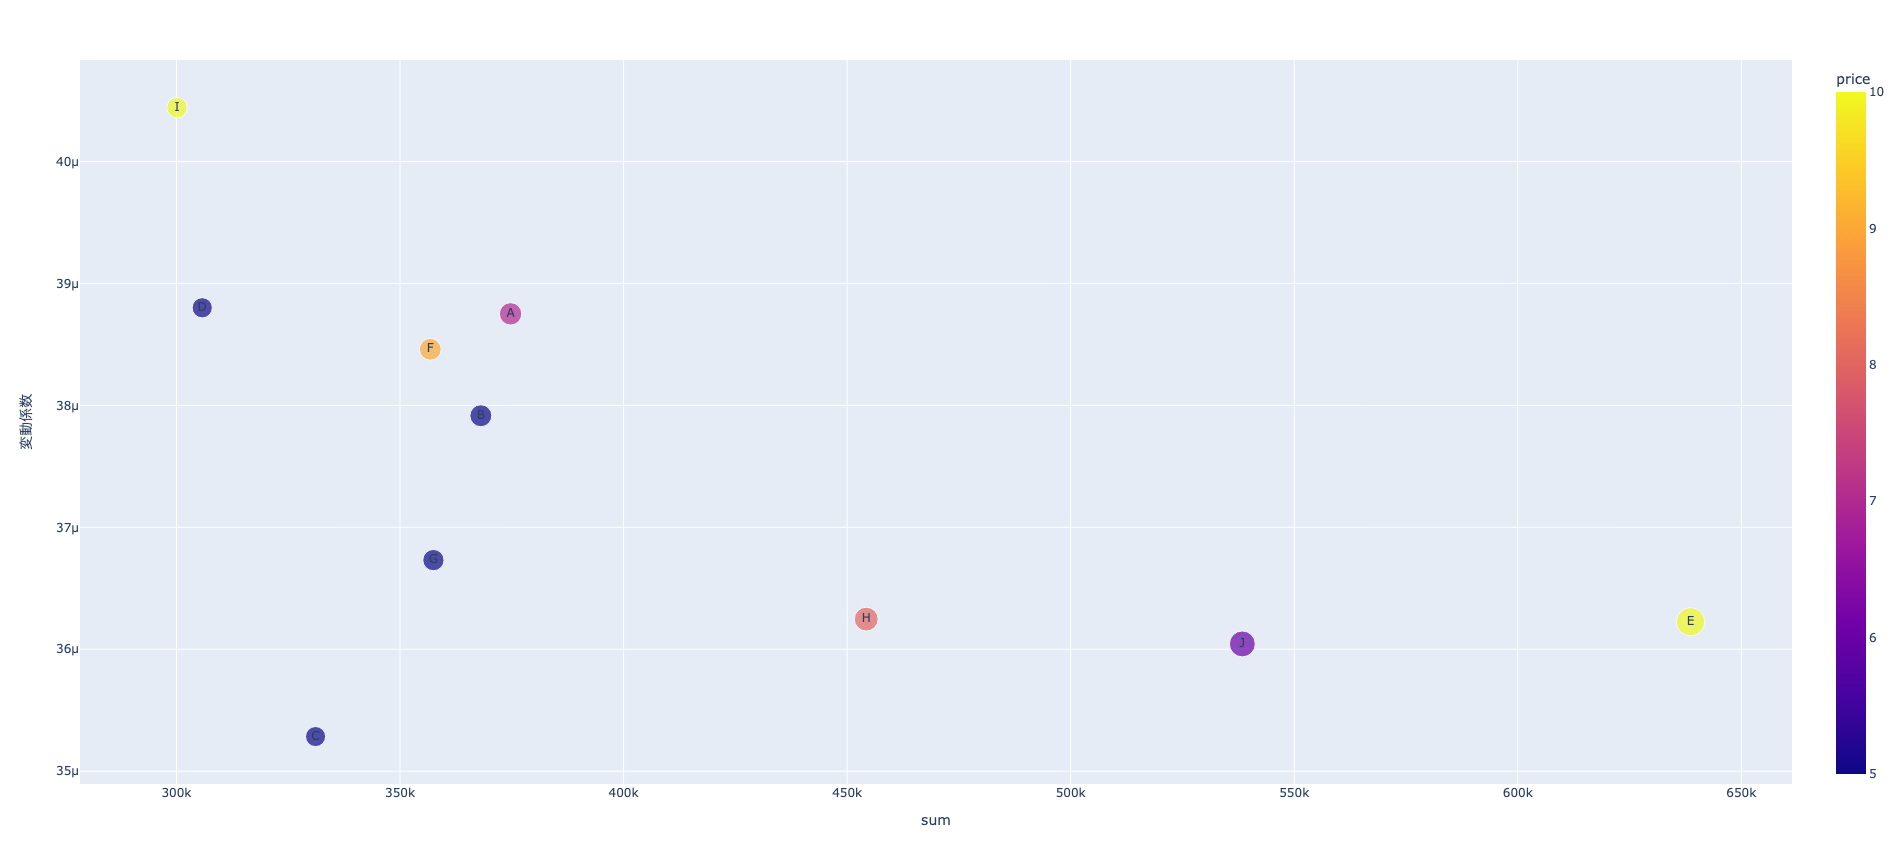

In [ ]:
#| echo: false
Image("../figure/show_mean_cv.png")

## 安全在庫、ロットサイズ、目標在庫（基在庫レベル）の設定関数 inventory_analysis

全ての需要が1つの工場で生産していると仮定したとき、その生産ロットサイズや安全在庫量は、古典的な経済発注量モデルと新聞売り子モデルで計算できる。

- 安全在庫量: 安全在庫係数 $z$, リード時間 $L$， 需要の標準偏差 $\sigma$ としたとき $z\sqrt{LT}\sigma$

- 経済発注量（生産ロットサイズ）: 生産固定費用 $FC$、需要の平均値 $d$、在庫費用 $h$ としたとき $\sqrt{2 FCd/h}$

- 保管費率（無次元）： $r$ は以下の量の和とする。

    1. 利子率（投資額利率）
    2. 保険料率: 製品の種類および企業の方針によっても異なる．
    3. 消耗費率および陳腐化率: 製品の腐敗，破損，目減りなどを考慮して計算
    4. 税率: 在庫に課せられる法的な税率（日本では0)
    
    
- 在庫費用： $h$ は、保管費率 $r$ に製品の価値（製品データのplnt_value列)を乗じたものを週あたりに換算したもの

- 目標在庫量 $=$ 基在庫レベル： 安全在庫量 $+$ リード時間内の需要量

- 初期在庫量 $=$ 目標在庫量に生産ロットサイズの半分を加えた量

引数：

- prod_df: 製品データフレーム
- demand_df: 多期間の製品別需要データフレーム
- inv_reduction_df : 標準偏差とその差と削減率を製品ごとに計算したデータフレーム
- z: 安全在庫係数　
- LT: リード時間 
- r: 年間保管費率
- num_days: 標準偏差を計算する際の日数（既定値は $7$）
        
返値： 以下の列情報を加えた製品データフレーム prod_df
        
- average_demand: num_days間の平均需要
- standard_deviation： 需要の標準偏差
- inv_cost： 在庫費用 $h = r \times $ plnt_value を1週間に換算したもの
- lot_size: 最適発注量
- safety_inventory: 安全在庫量
- target_inventory: 目標在庫量（基在庫レベル）；　 $d LT + z\sqrt{LT}\sigma$
- initial_inventory: 初期在庫量

In [ ]:
#| export
def inventory_analysis(prod_df: pd.DataFrame,
                       demand_df: pd.DataFrame,
                       inv_reduction_df: pd.DataFrame,
                       z: float = 1.65,
                       LT: int = 1,
                       r: float = 0.3,
                       num_days: int = 7) ->pd.DataFrame:
    """
    工場における安全在庫量の計算

    工場を１箇所に集約したと仮定する。複数工場の場合には、顧客と工場の紐付け情報が必要になる。
    """
    try:
        demand_df.reset_index(inplace=True)
    except:
        pass
    try:
        prod_df.reset_index(inplace=True)
    except:
        pass
    new_prod_df = prod_df.copy()
    
    demand_df["date"] = pd.to_datetime(demand_df.date)
    demand_df.set_index("date", inplace=True)
    periods = max((demand_df.index.max() - demand_df.index.min()).days, 1)  # 計画期間（日）
    # 工場における製品の総需要量（週の平均）を追加
    average_demand_df = pd.pivot_table(
        demand_df, index="prod", values="demand", aggfunc="sum")*num_days/periods  # per week
    new_prod_df["average_demand"] = average_demand_df.values

    # 工場における製品需要の標準偏差（週あたり）を追加
    inv_reduction_df.reset_index(inplace=True)
    inv_reduction_df.set_index("prod", inplace=True)
    inv_reduction_dic = inv_reduction_df.to_dict()
    agg_std_dic = inv_reduction_dic["agg_std"]
    col = []
    for row in new_prod_df.itertuples():
        col.append(agg_std_dic[row.name])
    new_prod_df["standard_deviation"] = col

    new_prod_df["inv_cost"] = r * new_prod_df.plnt_value /365.*7.  # inventory cost (per week)
    new_prod_df["lot_size"] = np.sqrt(
        2 * new_prod_df.fixed_cost*new_prod_df.average_demand/new_prod_df.inv_cost)
    new_prod_df["safety_inventory"] = z*math.sqrt(LT)*new_prod_df.standard_deviation
    new_prod_df["target_inventory"] = new_prod_df.safety_inventory + LT*new_prod_df.average_demand #基在庫レベル
    new_prod_df["initial_inventory"] = new_prod_df.safety_inventory + new_prod_df.target_inventory//2
    new_prod_df.set_index("index", inplace=True)
    return new_prod_df

### inventory_analysis関数の使用例

１週間を基本単位として、在庫量削減データフレームを計算し、それをもとに工場での在庫量を求める。

In [ ]:
prod_df = pd.read_csv(folder+"prod.csv",index_col=0)

inv_reduction_df = risk_pooling_analysis(demand_df, agg_period="1w")
new_prod_df = inventory_analysis(prod_df, demand_df, inv_reduction_df, z = 1.65, LT = 1, r = 0.3, num_days=7)
#prod_df2.to_csv(folder + "prod_with_inventory.csv")
new_prod_df.head()

,name,weight,volume,cust_value,dc_value,plnt_value,fixed_cost,average_demand,standard_deviation,inv_cost,lot_size,safety_inventory,target_inventory,initial_inventory
index,,,,,,,,,,,,,,
0,A,2,0,7,1,1,14,3598.172840,1363.027889,0.005753,4184.627560,2248.996017,5847.168857,5171.996017
1,B,5,0,5,1,1,14,3534.347051,1322.720355,0.005753,4147.347222,2182.488585,5716.835636,5040.488585
2,C,1,0,5,1,1,19,3179.353909,1120.054537,0.005753,4582.453009,1848.089986,5027.443895,4361.089986
3,D,3,0,5,1,1,17,2935.995885,1114.387806,0.005753,4165.373643,1838.739880,4774.735764,4225.739880
4,E,1,0,10,1,1,18,6132.412894,2192.456416,0.005753,6194.463943,3617.553086,9749.965980,8491.553086


## 生産・在庫シミュレーション inventory_simulation

上で生成したデータを用いて、シミュレーションを行う。生産は、安全在庫量を下回ったときに行われ、目標在庫量になるように生産量を決める。

TODO: NumPyで高速化， 様々な発注方策に対応

引数：
    
- prod_df: 製品データ
- demand_df: 需要データ
    
返値：
    
- キーを製品名、値を、需要 demand、在庫 inventory、生産量 production を列とした時系列データフレームとした辞書


In [ ]:
#| export
def inventory_simulation(prod_df: pd.DataFrame,
                         demand_df: pd.DataFrame
                        ) -> dict[str,pd.DataFrame]:
    """
    (Q,R)方策のシミュレーション
    """
    agg_period ="1d"
    LT = 1
    demand_df.reset_index(inplace=True)
    demand_df["date"] = pd.to_datetime(demand_df.date)
    demand_df.set_index("date", inplace=True)
    production_df = {}
    for row in prod_df.itertuples():
        p = row.name
        dem_for_prod = demand_df[demand_df["prod"] == p]
        dem = dem_for_prod.resample(agg_period)["demand"].sum()
        I = row.initial_inventory
        dic = OrderedDict()
        Prod = defaultdict(int) #initialized to 0
        for t, date in enumerate(dem.index):
            I = I - dem[date] + Prod[t-LT]
            if I < row.safety_inventory:
                Prod[t] = row.target_inventory - I
            dic[date] =[dem[date], I, Prod[t]]
        production_df[p] = pd.DataFrame.from_dict(dic, orient='index', columns=["demand", "inventory", "production"])
    return production_df

### inventory_simulation関数の使用例

製品 A に対する需要、在庫、生産量を表すデータフレームを表示する。

In [ ]:
production_df = inventory_simulation(new_prod_df, demand_df)
production_df[prod_df.name[0]].head()

,demand,inventory,production
2019-01-01,475,4696.996017,0.0
2019-01-02,688,4008.996017,0.0
2019-01-03,555,3453.996017,0.0
2019-01-04,449,3004.996017,0.0
2019-01-05,607,2397.996017,0.0


### 生産、在庫、需要の可視化関数 show_prod_inv_demand

引数：
    
- prod_name: 製品名
- production_df: 累積需要量、在庫量、生産量の列をもつデータフレーム
- scale: 時間の集約を表す文字列。たとえば1日ごとに表示する場合には "1d" とする。
    
返値：
    
- plotlyの図


In [ ]:
#| export
def show_prod_inv_demand(prod_name: str, 
                         production_df: pd.DataFrame,
                         scale: str="1d"
                        ) -> pd.DataFrame:
    """
    生産、在庫、需要の可視化関数
    """
    p = prod_name
    scale = scale
    df = production_df[p]["production"].resample(scale).sum()

    data = []
    trace = go.Scatter(
              x = list(df.index.astype('str')),
              y = production_df[p]["production"].resample(scale).sum().values.cumsum(),
              line = dict(
                  width = 2),
              name = "生産"
    )
    data.append( trace )

    trace = go.Scatter(
           x = list(df.index.astype('str')),
           y = production_df[p]["demand"].resample(scale).sum().values.cumsum(),
           line = dict(
              color = "green",
              width = 3),
           name = "需要"
        )
    data.append( trace )

    trace = go.Scatter(
           x = list(df.index.astype('str')),
           y = production_df[p]["inventory"].resample(scale).sum().values,
           line = dict(
              color = "orange",
              width = 1),
           name = "在庫"
        )
    data.append( trace )

    layout = go.Layout(
          title="生産，在庫，需要の関係",
          xaxis=dict(
            title='期'
          ),
          yaxis=dict(
            title='(累積）量'
          ),
        )
    fig = go.Figure(data=data, layout=layout)
    return fig

### show_prod_inv_demand関数の使用例

In [ ]:
fig = show_prod_inv_demand(prod_df.name[3], production_df, scale="1d")
#plotly.offline.plot(fig);

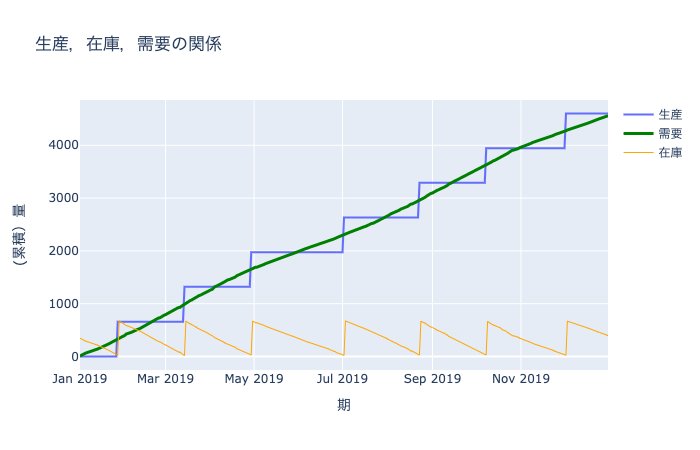

In [ ]:
#| echo: false
Image("../figure/prod_demand_inv.png")

## 需要量の可視化関数

In [ ]:
#| export
def plot_demands(prod_cust_list: List[str], 
                 demand_df: pd.DataFrame,
                 agg_period: str="1d"
                        ) -> pd.DataFrame:
    """
    需要の可視化関数
    """
    try:
        demand_df.reset_index(inplace=True)
    except:
        pass
    idx = pd.date_range(start=demand_df.date.min(), end=demand_df.date.max(), freq=agg_period)
    demand_df["date"] = pd.to_datetime(demand_df["date"])
    demand_df.set_index("date", inplace=True)
    demand_grouped = demand_df.groupby(
        ["prod", "cust"]).resample(agg_period)["demand"].sum()
    
    data = []
    for pc in prod_cust_list:
        prod, cust = pc.split(",")
        series = demand_grouped[(prod, cust)]
    
        trace = go.Scatter(
               x = series.index.astype('str'),
               y = series.values,
               line = dict(
                  width = 1),
               name = f"{prod},{cust}"
            )
        data.append( trace )
    layout = go.Layout(
          title="需要",
          xaxis=dict(
            title='期'
          ),
          yaxis=dict(
            title='需要量'
          ),
        )
    fig = go.Figure(data=data, layout=layout)
    return fig

In [ ]:
prod_cust_list = ["A,さいたま市","B,さいたま市", "E,佐賀市"]
fig = plot_demands(prod_cust_list, demand_df, agg_period="2w")

In [ ]:
#| echo: false
#この方が簡単?
# try:
#     demand_df.reset_index(inplace=True)
# except:
#     pass
# idx = pd.date_range(start=demand_df.date.min(), end=demand_df.date.max(), freq="1w")
# demand_df["date"] = pd.to_datetime(demand_df["date"])
# demand_df.set_index("date", inplace=True)
# demand_grouped = demand_df.groupby(
#     ["prod", "cust"]).resample(agg_period)["demand"].sum()
# idx = pd.IndexSlice
# df = demand_grouped.loc[idx[["A","J"],["さいたま市","佐賀市"]]]
# new_df = df.reset_index()
# new_df
#px.line(new_df, x="date", y="demand", color="prod", facet_row="cust")

## 基本分析クラス Scbas

上の関数を元にクラスを作る．

In [ ]:
#| export
class Scbas(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    # cust_df: Optional[pd.DataFrame] = None 
    # prod_df: Optional[pd.DataFrame] = None
    demand_df: pd.DataFrame
    
    agg_df_prod: Optional[pd.DataFrame] = None
    agg_df_cust: Optional[pd.DataFrame] = None
    new_demand_df: Optional[pd.DataFrame] = None
    reduction_df: Optional[pd.DataFrame] = None
    new_prod_df: Optional[pd.DataFrame] = None

    category_prod: Optional[Dict[int,List[str]]] = None 
    category_cust: Optional[Dict[int,List[str]]] = None 
    nodes: Optional[List[Dict]] = None
    
    agg_period: str ="1w",

    def demand_tree_map(self, 
                    parent: str = "cust",
                    value: str  = "demand") -> plotly.graph_objects.Figure:
        return demand_tree_map(self.demand_df, parent = parent, value = value)

    def generate_figures_for_abc_analysis(self, 
                                      value: str = "demand",
                                      cumsum: bool =True, 
                                      cust_thres: str = "0.7, 0.2, 0.1",
                                      prod_thres: str = "0.7, 0.2, 0.1"
                                     ) -> Tuple[plotly.graph_objects.Figure,plotly.graph_objects.Figure,
                                                pd.DataFrame,pd.DataFrame,pd.DataFrame] :
        fig_prod, fig_cust, agg_df_prod, agg_df_cust, new_df, self.category_prod, self.category_cust = generate_figures_for_abc_analysis(self.demand_df, value, cumsum, cust_thres, prod_thres)
        self.agg_df_prod, self.agg_df_cust, self.new_demand_df = agg_df_prod, agg_df_cust, new_df
        self.prepare_nodes()
        return fig_prod, fig_cust, agg_df_prod, agg_df_cust, new_df, self.category_prod, self.category_cust

    def prepare_nodes(self) -> None:
        #prepare nodes for tree lists
        nodes = []
        # 0,1,2 ...を　A,B,C ... に変換するための辞書 map_ を準備
        alphabet = string.ascii_uppercase
        map_ = {}
        for i, a in enumerate(alphabet):
            map_[i] = a
        
        for i, prods_in_rank in self.category_prod.items():
            nodes.append( {"label": f"{map_[i]} rank", 
                           "value": f"RANK[{map_[i]}]", 
                           "children": [ {"label": p, "value":f"{p}", "children": 
                                         [ {"label": f"{map_[j]} rank", 
                                           "value": f"RANK[{p},{map_[j]}]", 
                                           "children": [ {"label": c, "value":f"{p},{c}" } for c in custs_in_rank]
                                           }
                                            for j, custs_in_rank in self.category_cust.items()
                                         ]
                                         } for p in prods_in_rank]
                          }
                        )
        self.nodes = nodes
            
    def show_rank_analysis(self,
                               value: str ="demand", 
                               top_rank: int = 1
                      ) -> plotly.graph_objects.Figure:
        return show_rank_analysis(self.demand_df, self.agg_df_prod, value, self.agg_period, top_rank)

    def risk_pooling_analysis(self) -> pd.DataFrame:
        self.reduction_df = risk_pooling_analysis(self.demand_df, self.agg_period)
        return self.reduction_df 
    
    def show_mean_cv(self, prod_df: pd.DataFrame = None, 
                     show_name: bool =True
                ) -> plotly.graph_objects.Figure:
        return show_mean_cv(self.demand_df, prod_df, show_name)

    def inventory_analysis(self, prod_df: pd.DataFrame,
                       z: float = 1.65,
                       LT: int = 1,
                       r: float = 0.3,
                       num_days: int = 7) ->pd.DataFrame:
        if self.reduction_df is None: 
            self.reduction_df = self.risk_pooling_analysis()
        self.new_prod_df = inventory_analysis(prod_df, self.demand_df, self.reduction_df, z, LT, r, num_days)
        return self.new_prod_df 

In [ ]:
scbas = Scbas(demand_df=demand_df, agg_period= "1w")
fig = scbas.demand_tree_map(parent ="prod", value = "demand")
#plotly.offline.plot(fig);

In [ ]:
fig_prod, fig_cust, agg_df_prod, agg_df_cust, new_df, category_prod, category_cust = scbas.generate_figures_for_abc_analysis(
    value="demand", cumsum = False, cust_thres="0.7, 0.2, 0.1", prod_thres="0.7, 0.2, 0.1"
)
#plotly.offline.plot(fig_cust);
#scbas.nodes

In [ ]:
fig = scbas.show_rank_analysis(value="demand", top_rank = 10)
#plotly.offline.plot(fig);

In [ ]:
reduction_df = scbas.risk_pooling_analysis()
reduction_df.head()

,rank,prod,agg_std,sum_std,reduction
0,10,I,1137.883708,1138.748290,0.864583
1,8,C,1120.054537,1120.794951,0.740414
2,9,D,1114.387806,1115.096672,0.708866
3,4,A,1363.027889,1363.691051,0.663161
4,7,F,1282.927125,1283.552063,0.624938


In [ ]:
scbas = Scbas(demand_df=demand_df, agg_period= "1w")
fig = scbas.show_mean_cv(prod_df=prod_df, show_name=True)
#plotly.offline.plot(fig);

In [ ]:
scbas = Scbas(demand_df=demand_df, agg_period= "1w")
prod_df = pd.read_csv(folder+"prod.csv",index_col=0)
new_prod_df = scbas.inventory_analysis(prod_df, z = 1.65, LT = 1, r = 0.3, num_days=7)
new_prod_df.head().T

index,0,1,2,3,4
name,A,B,C,D,E
weight,2,5,1,3,1
volume,0,0,0,0,0
cust_value,7,5,5,5,10
dc_value,1,1,1,1,1
plnt_value,1,1,1,1,1
fixed_cost,14,14,19,17,18
average_demand,3598.17284,3534.347051,3179.353909,2935.995885,6132.412894
standard_deviation,1363.027889,1322.720355,1120.054537,1114.387806,2192.456416
inv_cost,0.005753,0.005753,0.005753,0.005753,0.005753
